0it [00:00, ?it/s]

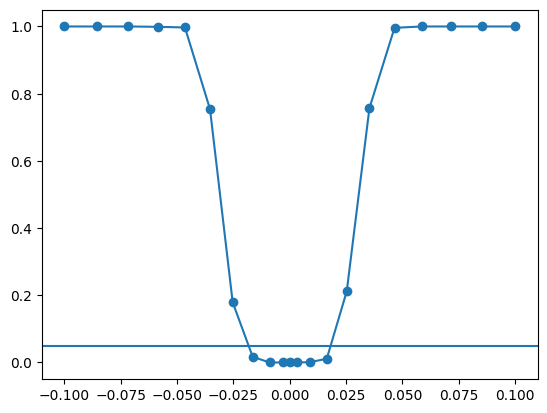

In [18]:
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt


def watson_mean_angle_test(angles, mu_0=0.0):
    """Watson's one-sample test for mean angle"""
    n = len(angles)
    c_bar = np.mean(np.cos(angles))
    s_bar = np.mean(np.sin(angles))
    R = np.sqrt(c_bar**2 + s_bar**2)
    mean_angle = np.arctan2(s_bar, c_bar)
    T = 2 * n * (R**2) * (1 - np.cos(mean_angle - mu_0))
    p_value = 1 - chi2.cdf(T, df=1)
    return T, p_value, mean_angle, R


def random_wrapped_normal(n, mu, sigma):
    """Generate wrapped normal samples"""
    z = np.random.normal(size=n)
    theta = (mu + sigma * z) % (2 * np.pi)
    return theta


# Simulation parameters
n_sims = 1000
sample_size = 5000
kappa = 5.0  # concentration parameter
sigma = 1 / np.sqrt(kappa)  # approximate relationship
alpha = 0.05

delta_rates = np.zeros(21)
delta_rates_std = np.zeros(21)
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.1 * np.sign(_x) * (np.abs(_x) ** 1.5)

rej_rate = np.zeros_like(deltas)

for j, delta in tqdm(enumerate(deltas)):
    null_pvals = np.zeros(n_sims)
    alt_pvals = np.zeros(n_sims)

    for i in range(n_sims):
        # Null hypothesis (mu = 0)
        null_sample = random_wrapped_normal(sample_size, delta, sigma)
        null_pvals[i] = watson_mean_angle_test(null_sample)[1]

    rej_rate[j] = np.mean(null_pvals < alpha)

plt.plot(deltas, rej_rate, marker="o")
plt.axhline(0.05)

In [ ]:
import numpy as np

times = np.array([22.5, 23.5, 0.5, 1.0, 2.5, 20.5, 21])

print("y", times / 24 * 4)
print("angles", 90 - times / 24 * 360)

angles = (90 - times / 24 * 360) / 180 * np.pi

print(times.mean(), ", scale=", times.mean() / 24 * 4)

print(np.c_[np.cos(angles), np.sin(angles)].mean(axis=0))

y [3.75       3.91666667 0.08333333 0.16666667 0.41666667 3.41666667
 3.5       ]
angles [-247.5 -262.5   82.5   75.    52.5 -217.5 -225. ]
13.071428571428571 , scale= 2.1785714285714284
[-0.14508044  0.85455952]
